In [22]:
# Torch
import torch

# Tensordict modules
from tensordict.nn import TensorDictModule
# 텐서 딕셔너리를 관리하고 모듈화 도움
from tensordict.nn.distributions import NormalParamExtractor
# 정규 분포 매개변수 추출에 사용
from torch import multiprocessing
# 병렬 처리를 통해 데이터 수집 및 훈련 속도 높임

# Data collection
from torchrl.collectors import SyncDataCollector
# 동기화된 데이터 수집기 제공. 환경에서 데이터를 효율적으로 수집하는 데 사용
from torchrl.data.replay_buffers import ReplayBuffer
# 경험 재생 버퍼 구현
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement
# 중복 없이 샘플을 추출하는 샘플러
from torchrl.data.replay_buffers.storages import LazyTensorStorage
# 텐서 저장소를 구현하여 데이터 메모리 사용을 효율화

# Env
from torchrl.envs import RewardSum, TransformedEnv
# rewardsum: 보상의 합계를 계산하는 데 사용되는 환경 변형 도구
# transformedenv: 환경을 변형하여 강화학습에 맞는 형태로 변경
from torchrl.envs.libs.vmas import VmasEnv
from my_vmas.scenarios.cooperative_exploration import Scenario                                      # 제작 시나리오
# 멀티 에이전트 시스템의 환경 라이브러리
from torchrl.envs.utils import check_env_specs
# 환경의 스펙이 올바르게 설정되었는지 검증

# Multi-agent network
from torchrl.modules import MultiAgentMLP, ProbabilisticActor, TanhNormal
# multiagentmlp: 멀티 에이전트용 다층 퍼셉트론 정의
# probabilisticactor: 확률적 행동 선택 담당
# tanhnormal: 하이퍼볼릭 탄젠트를 활용한 정규 분포로 정책을 정의

# Loss
from torchrl.objectives import ClipPPOLoss, ValueEstimators
# clipppoloss: ppo 알고리즘의 손실 함수
# valueestimators: 가치 추정 모델 관리

# Utils
torch.manual_seed(0)
# 결과의 재현성을 보장하기 위해 랜덤 시드 고정
from matplotlib import pyplot as plt
# 결과 시각화
from tqdm import tqdm
# 진행 상황을 시각적으로 보여주는 진행 바

In [23]:
# Devices
is_fork = multiprocessing.get_start_method() == "fork"
device = (
    torch.device(0)
    if torch.cuda.is_available() and not is_fork
    else torch.device("cpu")
)
vmas_device = device  # The device where the simulator is run (VMAS can run on GPU)
# 현재 멀티프로세싱 환경에서 fork가 사용되고 있는지 확인
# fork는 일부 gpu 작업에서 비호환성을 유발할 수 있기 때문에 이를 감안하여 디바이스 설정

# Sampling
frames_per_batch = 6_000  # Number of team frames collected per training iteration(반복) 초기 설정 6000
# 에이전트들이 환경에서 6000 프레임을 수행. 무슨 말이지
n_iters = 1000  # Number of sampling and training iterations
total_frames = frames_per_batch * n_iters

# Training
num_epochs = 10  # Number of optimization steps per training iteration(30)
minibatch_size = 6000  # Size of the mini-batches in each optimization step(400)
lr = 3e-4  # Learning rate(3e-4)
max_grad_norm = 1.0  # Maximum norm for the gradients
# 너무 큰 그래디언트를 방지하여 안정적인 학습을 도움

# PPO
clip_epsilon = 0.2  # clip value for PPO loss
gamma = 0.99  # discount factor
lmbda = 0.9  # lambda for generalised advantage estimation
entropy_eps = 1e-4  # coefficient of the entropy term in the PPO loss
# 엔트로피 보너스의 가중치를 조절하는 값. 에이전트의 행동 다양성을 높이기 위해 사용

In [24]:
max_steps = 500  # Episode steps before done, 초기 설정 100
# 한 에피소드의 스텝 제한
num_vmas_envs = (
    frames_per_batch // max_steps
)  # Number of vectorized envs. frames_per_batch should be divisible by this number
# frames_per_batch, max_steps를 이용해서 병렬 환경 수를 계산
# 지금은 6000//100 = 60개의 환경이 병렬로 돌아감
custom_scenario = Scenario()
scenario_name = "cooperative_exploration"
# vmas에서 제공하는 시뮬레이션 시나리오 중 하나 선택
n_agents = 1

env = VmasEnv(
    scenario=custom_scenario,
    num_envs=num_vmas_envs,
    continuous_actions=True,  # VMAS supports both continuous and discrete actions
    # 에이전트가 연속적인 행동을 할 수 있도록 설정. vmas는 연속 및 이산 행동을 모두 지원
    max_steps=max_steps,
    device=vmas_device,
    # Scenario kwargs
    n_agents=n_agents,  # These are custom kwargs that change for each VMAS scenario, see the VMAS repo to know more.
)

In [25]:
print("action_spec:", env.full_action_spec)     # 행동 공간
print("reward_spec:", env.full_reward_spec)     # 보상 영역
print("done_spec:", env.full_done_spec)         # 완료 영역
print("observation_spec:", env.observation_spec)    # 환경으로부터 관찰할 수 있는 모든 출력의 범위

# 아래의 출력이 뭘 뜻하는지는 아직 모르겠는데
# 나중에 내가 환경을 세팅하면 이에 관해서 확인을 하고 넘어가야하지 않을까..
# 환경의 설정이 적절한지 세팅값을 확인해보는 것 같음

action_spec: Composite(
    agents: Composite(
        action: BoundedContinuous(
            shape=torch.Size([12, 1, 2]),
            space=ContinuousBox(
                low=Tensor(shape=torch.Size([12, 1, 2]), device=cuda:0, dtype=torch.float32, contiguous=True),
                high=Tensor(shape=torch.Size([12, 1, 2]), device=cuda:0, dtype=torch.float32, contiguous=True)),
            device=cuda:0,
            dtype=torch.float32,
            domain=continuous),
        device=cuda:0,
        shape=torch.Size([12, 1])),
    device=cuda:0,
    shape=torch.Size([12]))
reward_spec: Composite(
    agents: Composite(
        reward: UnboundedContinuous(
            shape=torch.Size([12, 1, 1]),
            space=ContinuousBox(
                low=Tensor(shape=torch.Size([12, 1, 1]), device=cuda:0, dtype=torch.float32, contiguous=True),
                high=Tensor(shape=torch.Size([12, 1, 1]), device=cuda:0, dtype=torch.float32, contiguous=True)),
            device=cuda:0,
           

In [26]:
print("action_keys:", env.action_keys)
print("reward_keys:", env.reward_keys)
print("done_keys:", env.done_keys)

# 액션, 보상을 에이전트 별로 구분하여 독립적으로 관리
# 완료는 에피소드 공통으로 적용
# tensordict 형식의 데이터를 독립적으로 관리

action_keys: [('agents', 'action')]
reward_keys: [('agents', 'reward')]
done_keys: ['done', 'terminated']


In [27]:
env = TransformedEnv(
    env,
    RewardSum(in_keys=[env.reward_key], out_keys=[("agents", "episode_reward")]),
)

# 변환기능을 사용하여 환경의 입출력을 수정하는 기능
# 여기서는 다중 에이전트 환경에서 보상을 합산하는 변환을 추가한 것
# rewardsum: 보상 합상 변환. 에피소드 전체에 걸쳐 보상을 누적하여 기록
# in keys: 에이전트 별 보상
# out keys: 변환 결과 저장 위치, 에이전트의 하위 키인 에피소드 보상에 전체 보상 저장

In [28]:
check_env_specs(env)
# 환경에서 샘플 데이터를 생성하여 정확히 작동하는지 테스트

2025-02-28 15:37:33,126 [torchrl][INFO] check_env_specs succeeded!


In [29]:
n_rollout_steps = 5
rollout = env.rollout(n_rollout_steps)
print("rollout of three steps:", rollout)
print("Shape of the rollout TensorDict:", rollout.batch_size)
# 세팅 테스트

rollout of three steps: TensorDict(
    fields={
        agents: TensorDict(
            fields={
                action: Tensor(shape=torch.Size([12, 5, 1, 2]), device=cuda:0, dtype=torch.float32, is_shared=True),
                episode_reward: Tensor(shape=torch.Size([12, 5, 1, 1]), device=cuda:0, dtype=torch.float32, is_shared=True),
                observation: Tensor(shape=torch.Size([12, 5, 1, 21]), device=cuda:0, dtype=torch.float32, is_shared=True)},
            batch_size=torch.Size([12, 5, 1]),
            device=cuda:0,
            is_shared=True),
        done: Tensor(shape=torch.Size([12, 5, 1]), device=cuda:0, dtype=torch.bool, is_shared=True),
        next: TensorDict(
            fields={
                agents: TensorDict(
                    fields={
                        episode_reward: Tensor(shape=torch.Size([12, 5, 1, 1]), device=cuda:0, dtype=torch.float32, is_shared=True),
                        observation: Tensor(shape=torch.Size([12, 5, 1, 21]), device=cu

In [30]:
share_parameters_policy = True

policy_net = torch.nn.Sequential(
    MultiAgentMLP(
        n_agent_inputs=env.observation_spec["agents", "observation"].shape[
            -1
        ],  # n_obs_per_agent
        n_agent_outputs=2 * env.action_spec.shape[-1],  # 2 * n_actions_per_agents
        n_agents=env.n_agents,
        centralised=False,  # the policies are decentralised (ie each agent will act from its observation), False
        share_params=share_parameters_policy,
        device=device,
        depth=2,
        num_cells=256,
        activation_class=torch.nn.Tanh,
    ),
    NormalParamExtractor(),  # this will just separate the last dimension into two outputs: a loc and a non-negative scale
)
# 정책 네트워크 설정
# multiagentmlp: 다층 퍼셉트론 네트워크 설정
# centralised: 정보를 공유할 건지 선택하는 건데. 아래의 비평가랑 무슨 차이가 있는거지
# normalparamrxtractor: 네트워크 출력의 마지막 차원을 평균과 표준편차로 나눔

In [31]:
policy_module = TensorDictModule(
    policy_net,
    in_keys=[("agents", "observation")],
    out_keys=[("agents", "loc"), ("agents", "scale")],
)
# 신경망을 감싸라는데
# 입출력을 신경망에 연결시켜주는 거 같음

In [32]:
policy = ProbabilisticActor(
    module=policy_module,
    spec=env.unbatched_action_spec,
    in_keys=[("agents", "loc"), ("agents", "scale")],
    out_keys=[env.action_key],
    distribution_class=TanhNormal,
    distribution_kwargs={
        "low": env.unbatched_action_spec[env.action_key].space.low,
        "high": env.unbatched_action_spec[env.action_key].space.high,
    },
    return_log_prob=True,
    log_prob_key=("agents", "sample_log_prob"),
)  # we'll need the log-prob for the PPO loss
# 여기가 전체적인 정책을 정의하는 듯?

In [33]:
share_parameters_critic = True
mappo = True  # IPPO if False
# mappo: 전체 관찰 가능성을 갖춘 중앙 비평가
# ippo: 분산된 비평가. 

critic_net = MultiAgentMLP(
    n_agent_inputs=env.observation_spec["agents", "observation"].shape[-1],
    n_agent_outputs=1,  # 1 value per agent
    n_agents=env.n_agents,
    centralised=mappo,
    share_params=share_parameters_critic,
    device=device,
    depth=2,
    num_cells=256,
    activation_class=torch.nn.Tanh,
)

critic = TensorDictModule(
    module=critic_net,
    in_keys=[("agents", "observation")],
    out_keys=[("agents", "state_value")],
)

# 위의 1,2단계랑 상당히 유사함

In [34]:
print("Running policy:", policy(env.reset()))
print("Running value:", critic(env.reset()))

Running policy: TensorDict(
    fields={
        agents: TensorDict(
            fields={
                action: Tensor(shape=torch.Size([12, 1, 2]), device=cuda:0, dtype=torch.float32, is_shared=True),
                episode_reward: Tensor(shape=torch.Size([12, 1, 1]), device=cuda:0, dtype=torch.float32, is_shared=True),
                loc: Tensor(shape=torch.Size([12, 1, 2]), device=cuda:0, dtype=torch.float32, is_shared=True),
                observation: Tensor(shape=torch.Size([12, 1, 21]), device=cuda:0, dtype=torch.float32, is_shared=True),
                sample_log_prob: Tensor(shape=torch.Size([12, 1]), device=cuda:0, dtype=torch.float32, is_shared=True),
                scale: Tensor(shape=torch.Size([12, 1, 2]), device=cuda:0, dtype=torch.float32, is_shared=True)},
            batch_size=torch.Size([12, 1]),
            device=cuda:0,
            is_shared=True),
        done: Tensor(shape=torch.Size([12, 1]), device=cuda:0, dtype=torch.bool, is_shared=True),
        ter

In [35]:
collector = SyncDataCollector(
    env,
    policy,
    device=vmas_device,
    storing_device=device,
    frames_per_batch=frames_per_batch,
    total_frames=total_frames,
)
# 에이전트 정책이 환경과 상호작용하여 데이터를 수집
# 1. 환경 리셋
# 2. 최신 관찰을 사용하여 정책을 통해 행동 계산
# 3. 환경에서 스텝 실행
# 4. 마지막 두 단계를 반복하며, 환경이 멈추라는 신호를 보내거나 done이 될 때까지 계속 실행

In [36]:
replay_buffer = ReplayBuffer(
    storage=LazyTensorStorage(
        frames_per_batch, device=device
    ),  # We store the frames_per_batch collected at each iteration
    sampler=SamplerWithoutReplacement(),
    batch_size=minibatch_size,  # We will sample minibatches of this size
)
# 학습에 쓴다는데?
# batch size가 여기서 등장하네?

In [37]:
loss_module = ClipPPOLoss(
    actor_network=policy,
    critic_network=critic,
    clip_epsilon=clip_epsilon,
    entropy_coef=entropy_eps,
    normalize_advantage=False,  # Important to avoid normalizing across the agent dimension
)
loss_module.set_keys(  # We have to tell the loss where to find the keys
    reward=env.reward_key,
    action=env.action_key,
    sample_log_prob=("agents", "sample_log_prob"),
    value=("agents", "state_value"),
    # These last 2 keys will be expanded to match the reward shape
    done=("agents", "done"),
    terminated=("agents", "terminated"),
)


loss_module.make_value_estimator(
    ValueEstimators.GAE, gamma=gamma, lmbda=lmbda
)  # We build GAE
GAE = loss_module.value_estimator

optim = torch.optim.Adam(loss_module.parameters(), lr)

In [38]:
import os
print(os.getcwd())


/home/ksh-server/workspace/ICUFN/ciderlab


In [39]:
pbar = tqdm(total=n_iters, desc="episode_reward_mean = 0")
# 학습 진행상황 시각화

episode_reward_mean_list = []

collect_num = 0

# 학습 중 평균 에피소드 보상 저장
for tensordict_data in collector:
    # 학습 데이터 기록
    # torch.save(tensordict_data, f"collected_data/collected_data_{collect_num}.pt")
    collect_num += 1
    
    # 수집된 데이터를 반복적으로 처리
    tensordict_data.set(
        ("next", "agents", "done"),
        tensordict_data.get(("next", "done"))
        .unsqueeze(-1)
        .expand(tensordict_data.get_item_shape(("next", env.reward_key))),
    )
    tensordict_data.set(
        ("next", "agents", "terminated"),
        tensordict_data.get(("next", "terminated"))
        .unsqueeze(-1)
        .expand(tensordict_data.get_item_shape(("next", env.reward_key))),
    )
    # We need to expand the done and terminated to match the reward shape (this is expected by the value estimator)
    # done, terminated의 데이터 형식을 reward랑 동일하게 맞춰서 처리가 가능하도록 함

    with torch.no_grad():
        GAE(
            tensordict_data,
            params=loss_module.critic_network_params,
            target_params=loss_module.target_critic_network_params,
        )  # Compute GAE and add it to the data
    # GAE는 advantage 값을 계산하는 방법으로, 에이전트가 특정 행동을 했을 때 얼마나 좋은 결과를 얻을 수 있을지를 평가
    # torch.no_grad: 학습이 아닌 데이터 계산임으로 그래디언트 추적 안함...왜?? 학습 아니었어..?

    data_view = tensordict_data.reshape(-1)  # Flatten the batch size to shuffle data
    replay_buffer.extend(data_view)
    # 데이터를 평탄화 후, 리플레이 버퍼에 저장
    # 평탄화는 데이터를 랜덤하게 섞고 샘플링하기 쉽게 만듦
    # 데이터를 랜덤하게 왜 섞는데..?

    for _ in range(num_epochs):
        for _ in range(frames_per_batch // minibatch_size):
            subdata = replay_buffer.sample()
            loss_vals = loss_module(subdata)

            loss_value = (
                loss_vals["loss_objective"]
                + loss_vals["loss_critic"]
                + loss_vals["loss_entropy"]
            )

            loss_value.backward()

            torch.nn.utils.clip_grad_norm_(
                loss_module.parameters(), max_grad_norm
            )  # Optional

            optim.step()
            optim.zero_grad()
    # 데이터를 미니배치로 샘플링(replay buffer sample)한 후, 손실 계산

    collector.update_policy_weights_()
    # 정책 가중치 업데이트

    # Logging
    done = tensordict_data.get(("next", "agents", "done"))
    episode_reward_mean = (
        tensordict_data.get(("next", "agents", "episode_reward"))[done].mean().item()
    )
    # 에피소드가 종료된 상태에서 평균 에피소드 보상을 계산하고 저장
    episode_reward_mean_list.append(episode_reward_mean)
    pbar.set_description(f"episode_reward_mean = {episode_reward_mean}", refresh=False)
    pbar.update()
    # 진행률 표시줄에 업데이트된 평균 보상 표시

episode_reward_mean = -5.0000200271606445: 100%|██████████| 100/100 [18:18<00:00, 10.99s/it]


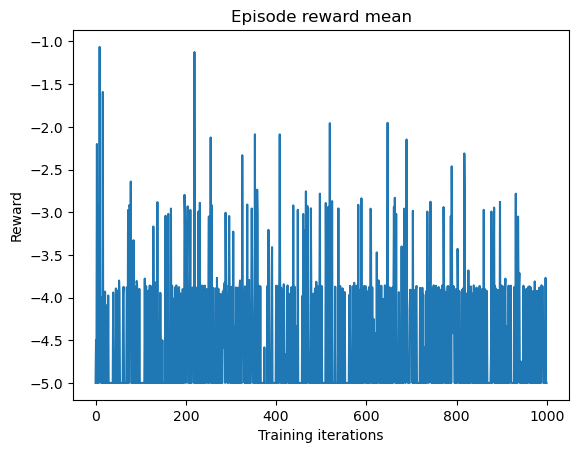

In [40]:
plt.plot(episode_reward_mean_list)
plt.xlabel("Training iterations")
plt.ylabel("Reward")
plt.title("Episode reward mean")
plt.show()

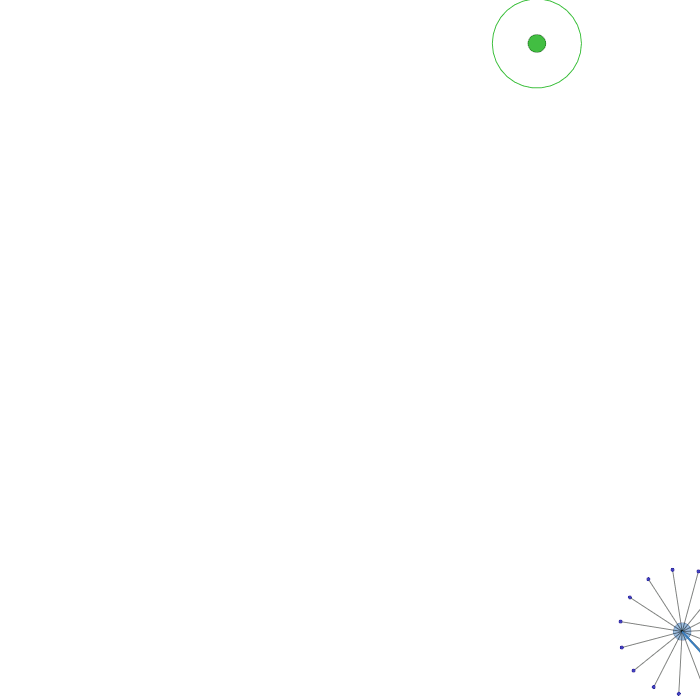

In [41]:
import pyvirtualdisplay
display = pyvirtualdisplay.Display(visible=False, size=(1000, 1000))
display.start()
from PIL import Image

def rendering_callback(env, td):
    env.frames.append(Image.fromarray(env.render(mode="rgb_array")))
env.frames = []
with torch.no_grad():
   env.rollout(
       max_steps=max_steps,
       policy=policy,
       callback=rendering_callback,
       auto_cast_to_device=True,
       break_when_any_done=False,
   )
env.frames[0].save(
    f"{scenario_name}.gif",
    save_all=True,
    append_images=env.frames[1:],
   duration=3,
   loop=0,
)

from IPython.display import Image
Image(open(f"{scenario_name}.gif", "rb").read())